# Graph Database Exploration
* Author: Jeffery Brown
* Topic: Graph Database, Neo4j
* GitHub Repo: https://github.com/daddyjab/GraphDB_Notes


In [1]:
# Dependencies

# Standard
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Neo4j driver for Python
from py2neo import Graph

# Style settings
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Connect to the Graph Database

In [2]:
# Connect to graph database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "graphdb") )
graph_cit = Graph("http://52.23.177.159:36681", auth=("neo4j", "supervisor-diaphragm-switches") )

In [3]:
graph

<Graph database=<Database uri='bolt://localhost:7687' secure=False user_agent='py2neo/4.3.0 neobolt/1.7.16 Python/3.6.9-final-0 (win32)'> name='data'>

In [4]:
graph_cit

<Graph database=<Database uri='http://52.23.177.159:36681' secure=False user_agent='py2neo/4.3.0 urllib3/1.24.3 Python/3.6.9-final-0 (win32)'> name='data'>

# Explore the Graph Database

In [5]:
# Retrieve the database schema
graph.run("CALL db.schema()").data()

[{'nodes': [(_-5:Movie {constraints: [], indexes: [], name: 'Movie'}),
   (_-6:Person {constraints: [], indexes: [], name: 'Person'})],
  'relationships': [(Person)-[:ACTED_IN {}]->(Movie),
   (Person)-[:REVIEWED {}]->(Movie),
   (Person)-[:PRODUCED {}]->(Movie),
   (Person)-[:WROTE {}]->(Movie),
   (Person)-[:FOLLOWS {}]->(Person),
   (Person)-[:DIRECTED {}]->(Movie)]}]

In [61]:
query = "MATCH path=(p:Person)-[r:ACTED_IN]->(m:Movie) RETURN m.title AS `Movie Title`, p.name AS `Actor Name`, r.roles AS `Roles Performed`"
m_df = graph.run(query).to_data_frame()
m_df

,Movie Title,Actor Name,Roles Performed
0,The Matrix,Emil Eifrem,[Emil]
1,The Matrix,Hugo Weaving,[Agent Smith]
2,The Matrix,Laurence Fishburne,[Morpheus]
3,The Matrix,Carrie-Anne Moss,[Trinity]
4,The Matrix,Keanu Reeves,[Neo]
...,...,...,...
167,A League of Their Own,Madonna,"[""All the Way"" Mae Mordabito]"
168,A League of Their Own,Rosie O'Donnell,[Doris Murphy]
169,A League of Their Own,Geena Davis,[Dottie Hinson]
170,A League of Their Own,Bill Paxton,[Bob Hinson]


In [63]:
graph_cit.run("CALL db.labels()").data()

ClientError: SyntaxError: Variable `label` not defined (line 1, column 25 (offset: 24))
"CALL db.labels() RETURN label"
                         ^

In [12]:
graph_cit.run("CALL db.relationshipTypes()").data()

[{'relationshipType': 'VENUE'},
 {'relationshipType': 'AUTHOR'},
 {'relationshipType': 'CITED'}]

In [58]:
query_cit = "CALL db.schema.relTypeProperties()"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,relType,propertyName,propertyTypes,mandatory
0,:`VENUE`,None,None,False
1,:`AUTHOR`,None,None,False
2,:`CITED`,None,None,False


In [59]:
query_cit = "CALL db.schema.nodeTypeProperties()"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,nodeType,nodeLabels,propertyName,propertyTypes,mandatory
0,:`Author`,[Author],name,[String],True
1,:`Venue`,[Venue],name,[String],True
2,:`Article`,[Article],index,[String],True
3,:`Article`,[Article],title,[String],True
4,:`Article`,[Article],year,[Long],True
5,:`Article`,[Article],n_citation,[Long],False
6,:`Article`,[Article],abstract,[String],False


In [60]:
# query="CALL dbms.security.listUsers()"
# query="CALL dbms.security.listRoles()"
# query="CALL dbms.security.listRoles()"
# query="CALL dbms.listConnections()"query_cit = "MATCH path=(n)-[r:AUTHOR]-(a) RETURN a, labels(a), n, labels(n), r, Type(r) LIMIT 10"
query_cit = "MATCH ()-[r]-() RETURN r LIMIT 10"
query_cit = "MATCH (n) RETURN labels(n), keys(n), size(keys(n)), count(*) ORDER BY size(keys(n)) DESC"
query_cit = "MATCH (n) RETURN properties(n) LIMIT 100"
query_cit = "MATCH (n) UNWIND keys(n) as key_item WITH key_item ORDER BY key_item RETURN collect(DISTINCT key_item) AS `Node Keys` LIMIT 10"
query_cit = "MATCH ()-[r]-() UNWIND keys(r) as key_item WITH key_item ORDER BY key_item RETURN collect(DISTINCT key_item) AS `Node Keys` LIMIT 10"
query_cit = "MATCH path=(a:Article)-[r]->(n) WHERE EXISTS (a.abstract) RETURN DISTINCT a.title AS `Article Title`, size(a.abstract) AS `Abstract Size`, a.abstract ORDER BY `Abstract Size` DESC LIMIT 10"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,Article Title,Abstract Size,a.abstract
0,Programming pearls,8810,From the Book:#R##N#PREFACE: #R##N#Computer pr...
1,A simple approach to specifying concurrent sys...,8411,"Over the past few years, I have developed an a..."
2,Intelligent support for the engineering of sof...,7886,Engineers of large systems must be concerned w...
3,NEST: a network simulation and prototyping tes...,7814,The Network Simulation Testbed (NEST) is a gra...
4,"Computing, research, and war: if knowledge is ...",7613,"In the United States, artificial intelligence ..."
5,Reversing the landslide in computer-related de...,6796,Introduction There is growing concern that ...
6,The social influence model of technology adoption,6728,"Introduction Human innovation, in combinati..."
7,Understanding object-oriented: a unifying para...,6481,The need to develop and maintain large complex...
8,Becoming a computer scientist,6248,It is well known that women are significantly ...
9,Model Predictive Control of regulation service...,6053,Model Predictive Control of Regulation Service...


In [65]:
result = {"label": [], "count": []}
for label in graph_cit.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph_cit.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


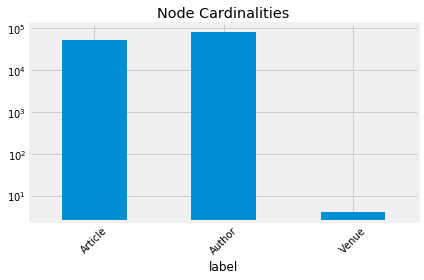

In [66]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [68]:
result = {"relType": [], "count": []}
for relationship_type in graph_cit.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph_cit.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


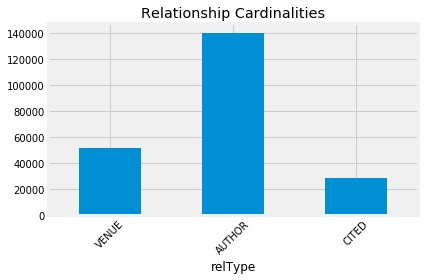

In [69]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, collect(DISTINCT author.name) AS author_list, collect(venue.name) AS venue_list, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY citationsReceived DESC, citationsGiven DESC
LIMIT 25
"""

graph_cit.run(exploratory_query).to_data_frame()

,article,author_list,venue_list,citationsGiven,citationsReceived
0,Rough sets,"[Roman Słowiński, Jerzy W. Grzymala-Busse, Zdz...","[Communications of The ACM, Communications of ...",0,211
1,A method for obtaining digital signatures and ...,"[Adi Shamir, Leonard M. Adleman, Ronald L. Riv...","[Communications of The ACM, Communications of ...",1,125
2,"Pastry: Scalable, Decentralized Object Locatio...","[Antony I. T. Rowstron, Peter Druschel]","[Lecture Notes in Computer Science, Lecture No...",1,108
3,An axiomatic basis for computer programming,[C. A. R. Hoare],[Communications of The ACM],0,93
4,"Time, clocks, and the ordering of events in a ...",[Leslie Lamport],[Communications of The ACM],0,86
5,Symbolic execution and program testing,[James C. King],[Communications of The ACM],0,70
6,N degrees of separation: multi-dimensional sep...,"[Peri L. Tarr, William H. Harrison, M Stanley ...",[international conference on software engineer...,0,68
7,Dynamically discovering likely program invaria...,"[Michael D. Ernst, David Notkin, William G. Gr...",[international conference on software engineer...,9,66
8,Software agents,"[Michael R. Genesereth, Steven P. Ketchpel]","[Communications of The ACM, Communications of ...",0,63
9,Maintaining knowledge about temporal intervals,[James F. Allen],[Communications of The ACM],0,62
